In [6]:
from torax.config.config_loader import build_sim_and_runtime_params_from_config_module
from torax.simulation_app import main
from torax.output import load_state_file
from torax import set_jax_precision
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import chex

set_jax_precision()

In [7]:
sim, runtime_params = build_sim_and_runtime_params_from_config_module('torax.examples.strange_solution', None)
output_file = main(
    lambda: sim,
    log_sim_progress=True,
    plot_sim_progress=False,
    log_sim_output=False,
)

2025-02-11 12:22:10,263 [    INFO] 
          Config input Zeff not directly defined at rhonorm=1.0.
          Zeff_face at rhonorm=1.0 set from constant values or constant extrapolation.
          
2025-02-11 12:22:10,279 [    INFO] 
          Config input Zeff not directly defined at rhonorm=1.0.
          Zeff_face at rhonorm=1.0 set from constant values or constant extrapolation.
          
2025-02-11 12:22:10,668 [    INFO] Setting electron temperature boundary condition using Te.
2025-02-11 12:22:10,671 [    INFO] Setting ion temperature boundary condition using Ti.
2025-02-11 12:22:19,697 [    INFO] Starting simulation.
2025-02-11 12:22:19,700 [    INFO] Precision is set at float64
2025-02-11 12:22:19,702 [    INFO] Starting simulation.
/media/data/OpenStar/2425/torax/torax/geometry/geometry.py:272: RuntimeWarning: invalid value encountered in divide
  return jnp.nan_to_num(self.g1_face / self.vpr_face, nan=0.0)
/media/data/OpenStar/2425/torax/torax/geometry/geometry.py:272: Run

The equation TORAX solves for density is:
$$
\left(\frac{\partial}{\partial t}-\frac{\dot{\Phi}_b}{2\Phi_b}\frac{\partial}{\partial \hat\rho}\hat\rho\right)\left[n_eV'\right] = \frac{\partial}{\partial\hat\rho}\left[D_e\frac{g_1}{V'}\frac{\partial n_e}{\partial\hat\rho}-g_0V_en_e\right]+S_n V'
$$
Assuming equilibrium, and no sources, this reduces to:
$$
\frac{\partial}{\partial\hat\rho}\left[D_e\frac{g_1}{V'}\frac{\partial n_e}{\partial\hat\rho}-g_0V_en_e\right]=0
$$
Which can be integrated to find:
$$
\frac{\partial n_e}{\partial\hat\rho}-\frac{g_0V_e}{D_e\frac{g_1}{V'}}n_e = \frac{c_1}{D_e\frac{g_1}{V'}}
$$
This is a linear, first-order ODE, which can be solved easily.

The solution is:
$$
n_e = \frac{1}{\mu(\hat\rho)}\left[\int\mu(\hat\rho)q(\hat\rho)d\hat\rho+c_2\right]
$$
Where:
$$
\mu(x) = \exp\left(\int p(x)dx\right)
$$
$$
p(x) = -\frac{g_0V_e}{D_e\frac{g_1}{V'}}
$$
$$
q(x) =\frac{c_1}{D_e\frac{g_1}{V'}}
$$

$c_1$ and $c_2$ are determined by the boundary conditions.

2025-02-11 12:24:47,721 [    INFO] Loading state file /tmp/torax_results_20250211_122219/state_history.nc


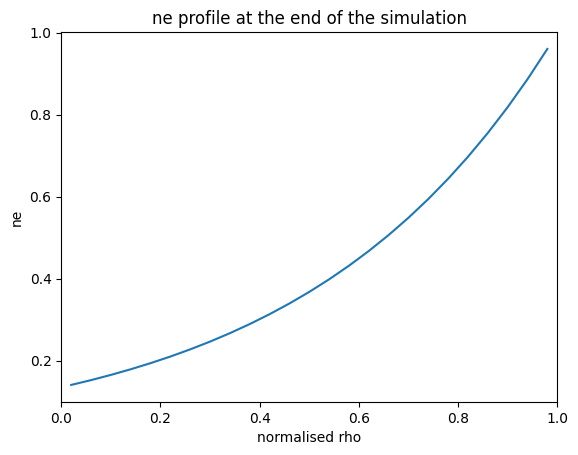

In [8]:
data = load_state_file(output_file)
rho_hats = data.rho_cell_norm.to_numpy()
ne_sim = data.core_profiles.ne.to_numpy()[-1]
plt.plot(rho_hats, ne_sim)
plt.xlabel('normalised rho')
plt.ylabel('ne')
plt.title('ne profile at the end of the simulation')
plt.xlim(0, 1)
plt.show()

# Equilibrium ODE Solver

This solves for the equilibrium solution, based on the geometrical and transport coefficient profiles.

Note that this won't work for the unmodified version of TORAX, because some of the required profiles are not actually outputted.

In [9]:
def cumulative_integrate(y: jax.Array, x: jax.Array) -> jax.Array:
    return jnp.concatenate([jnp.array([0.0]), 0.5 * (jnp.diff(x) * (y[1:] + y[:-1])).cumsum()])


def solve_ode(
        grid: jax.Array,
        a: jax.Array, b: jax.Array, c: jax.Array,
        left_boundary: jax.Array, right_boundary: jax.Array,
        left_boundary_is_grad: bool, right_boundary_is_grad: bool,
) -> tuple[jax.Array, float, float]:
    """Solves an ODE of the form a(x) y' + b(x) y = c(x) + C_1."""
    p = b / a
    int_p = cumulative_integrate(p, grid)
    mu = jnp.exp(int_p)

    int_mu_over_a = cumulative_integrate(mu / a, grid)
    int_mu_times_source = cumulative_integrate(mu * c / a, grid)

    def ys(c1, c2):
        chex.assert_equal_shape([c1, c2])
        f = lambda c1, c2: c2 / mu + c1 / mu * int_mu_over_a + 1 / mu * int_mu_times_source
        if c1.shape == ():
            return f(c1, c2)
        return jax.vmap(f)(c1, c2)

    def left_boundary_(c1, c2):
        if left_boundary_is_grad:
            return jnp.gradient(ys(c1, c2))[0]
        else:
            return ys(c1, c2)[0]

    def right_boundary_(c1, c2):
        if right_boundary_is_grad:
            return jnp.gradient(ys(c1, c2))[-1]
        else:
            return ys(c1, c2)[-1]

    initial_c1 = jnp.array(0.0)
    initial_c2 = jnp.array(0.0)

    dleft_dc1, dleft_dc2 = jax.grad(left_boundary_, argnums=(0, 1))(initial_c1, initial_c2)
    dright_dc1, dright_dc2 = jax.grad(right_boundary_, argnums=(0, 1))(initial_c1, initial_c2)

    left_change = left_boundary - left_boundary_(initial_c1,  initial_c2)
    right_change = right_boundary - right_boundary_(initial_c1, initial_c2)

    c1, c2 = jnp.linalg.solve(
        jnp.array([[dleft_dc1, dleft_dc2], [dright_dc1, dright_dc2]]),
        jnp.array([left_change, right_change])
    ) + jnp.array([initial_c1, initial_c2])

    return ys(c1, c2), c1, c2

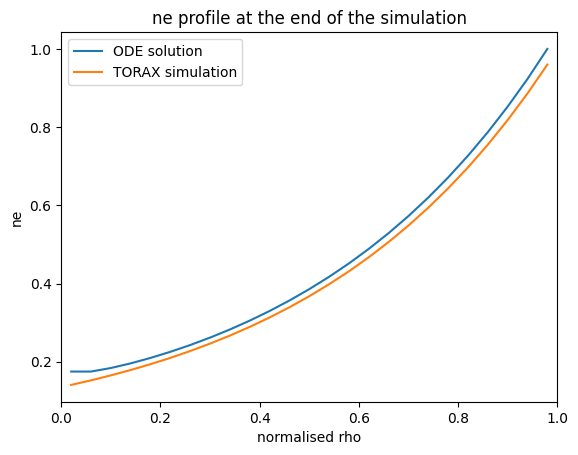

In [12]:
vpr = data.vpr.to_numpy()
d_face = data.core_transport.d_face_el.to_numpy()[-1]
v_face = data.core_transport.v_face_el.to_numpy()[-1]
d_cell = (d_face[1:] + d_face[:-1]) / 2
v_cell = (v_face[1:] + v_face[:-1]) / 2
g0 = data.g0.to_numpy()
g1 = data.g1.to_numpy()

ne_source = jnp.zeros_like(rho_hats)
ne_source_integral = cumulative_integrate(ne_source * vpr, rho_hats)
ne_p = -v_cell * g0 * vpr / (d_cell * g1)
ne_q = -vpr / (d_cell * g1) * ne_source_integral

ne_left_boundary = 0.0
ne_right_boundary = 1.0
ne_left_boundary_is_grad = True
ne_right_boundary_is_grad = False

ne_sol, _, _ = solve_ode(
    rho_hats, d_cell * g1 / vpr, -g0 * v_cell, ne_source_integral,
    jnp.array(ne_left_boundary), jnp.array(ne_right_boundary),
    ne_left_boundary_is_grad, ne_right_boundary_is_grad,
)

plt.plot(rho_hats, ne_sol)
plt.plot(rho_hats, ne_sim)
plt.legend(['ODE solution', 'TORAX simulation'])
plt.xlabel('normalised rho')
plt.ylabel('ne')
plt.title('ne profile at the end of the simulation')
plt.xlim(0, 1)
plt.show()